In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from time import sleep
from tqdm import tqdm
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
from math import cos, sin, pi
import numpy as np
from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result, trajectory_polar_comparison,find_ideal_R, position_finder_mean
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, move_stage, beat_to_center, center_object, optimal_z_position
import csv
import random
import os
import json
import pycromanager
#from pipython.datarectools import getservotime
import cv2
#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

C:\Users\jschulz\AppData\Local\Temp\ipykernel_16112\587672327.py:22: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [2]:
data_path = 'Y:\\Julian\\Hydrogel\\measurement_2'
file_list = os.listdir(data_path)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Y:\\Julian\\Hydrogel\\measurement_2'

In [113]:
file_list

['10_khz_Export_20231006_112401.avi',
 '1_khz_Export_20231006_104624.avi',
 '25_khz_Export_20231006_140921.avi',
 '50_khz_Export_20231006_121201.avi',
 '5_khz_Export_20231006_105529.avi']

In [114]:
file_path = os.path.join(data_path,file_list[-1])

In [115]:
file_path

'Y:\\Julian\\Hydrogel\\measurement_2\\5_khz_Export_20231006_105529.avi'

In [116]:
def movie_to_array(video_path, channel=0, max_frames=None):
    """
    Convert a movie to a numpy array with the option to truncate the movie.
    """

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_slices = []

    if max_frames is not None:
        total_frames = min(total_frames, max_frames)

    # Add tqdm progress bar
    for _ in tqdm(range(total_frames), desc="Processing video", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        threshold = 8
        image = frame[2:, :, channel]
        image[image<threshold] = threshold
        image = image - threshold

        frame_slices.append(image)

    cap.release()

    # Adjust the dimensions so that movie[0] is the first frame
    return np.array(frame_slices).astype(np.int32)

In [117]:
numpy_movie = movie_to_array(file_path, max_frames=200)

Processing video: 100%|██████████| 200/200 [00:00<00:00, 11796.33frame/s]


In [127]:
numpy_movie.shape

(200, 74, 128)

In [129]:
movie_even = numpy_movie[:, ::2, :]
movie_odd = numpy_movie[:, 1::2, :]

In [130]:
movie_odd.shape

(200, 37, 128)

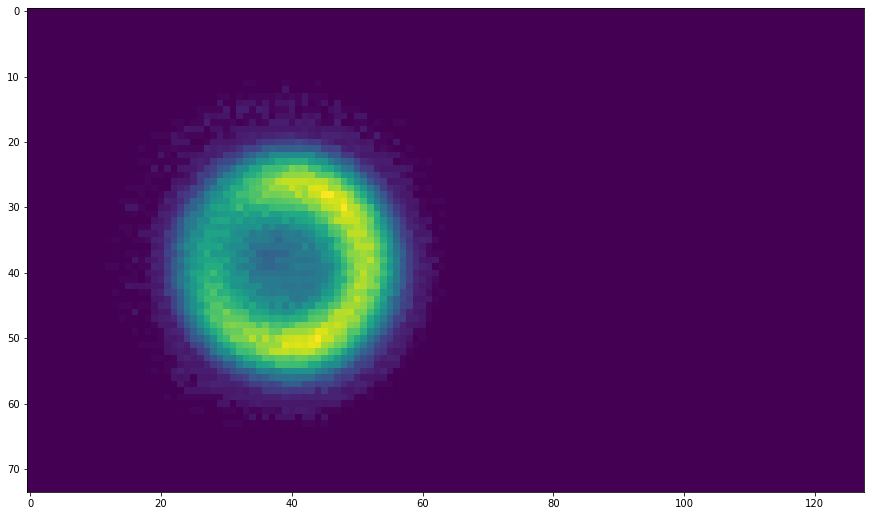

In [93]:
# Define the figure size
plt.figure(figsize=(15, 15))
image = numpy_movie[50]

plt.imshow(image)
plt.show()


In [94]:
tra_mean = trajectory_mean(numpy_movie, logging_enabled=True)
tra_corr = trajectory_corr(numpy_movie)
tra_gauss = trajectory_gauss(numpy_movie)


100%|██████████| 199/199 [00:00<00:00, 237.82it/s]
c:\Users\BetzLab-Admin\Desktop\git-code\mbr_relevant_code\experiments\hydrogel_measurements\../../lib\detection_methods.py:217: RuntimeWarning: invalid value encountered in sqrt
  return popt, np.sqrt(np.diag(pcov))


In [95]:
tra_till = trajectory_till_stepwise(numpy_movie)

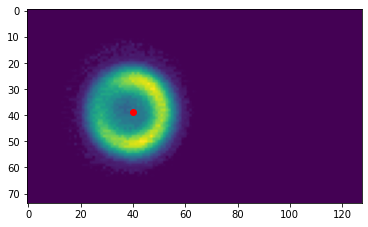

In [96]:
frame = 100
image = numpy_movie[frame]
position_mean = position_finder_mean(image)
plt.imshow(image)
plt.scatter(position_mean[1],position_mean[0],c='r')

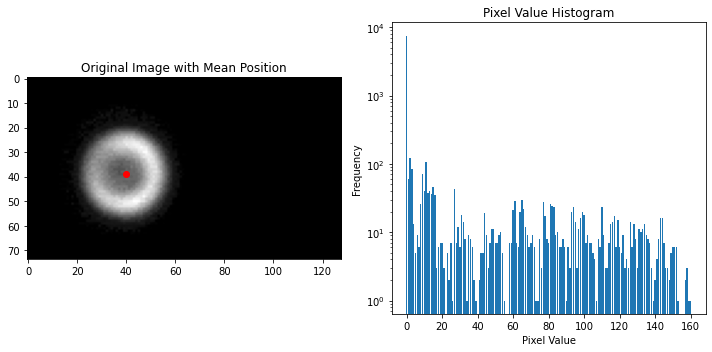

In [97]:
# Plot the image with the mean position
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.imshow(image, cmap='gray')
plt.scatter(position_mean[1], position_mean[0], c='r')
plt.title('Original Image with Mean Position')

# Create a histogram
values, counts = np.unique(image, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]  # Indices of pixel values sorted by count (descending)

# Display the histogram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.bar(values, counts)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Pixel Value Histogram')
plt.tight_layout()
plt.show()




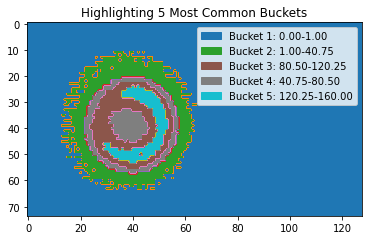

In [98]:
import matplotlib.patches as mpatches

# Number of buckets
n = 5

# Determine the range for each bucket
max_pixel_value = image.max()

# First bucket is specifically for the value 0. The remaining values are distributed equally
bucket_ranges = [0, 1]  # Start and end of the first bucket
bucket_ranges += list(np.linspace(1 + (max_pixel_value-1)/(n-1), max_pixel_value, n-1))

# Assign each pixel to a bucket
bucket_assignment = np.digitize(image, bucket_ranges) - 1  # Subtract 1 to make the first bucket 0

# Calculate the frequency of each bucket
_, bucket_counts = np.unique(bucket_assignment, return_counts=True)
sorted_bucket_indices = np.argsort(bucket_counts)[::-1]

# Find the n most common buckets
n_most_common_buckets = sorted_bucket_indices[:n]

# Create a new image to display
bucket_image = np.zeros_like(image, dtype=float)

# Assign each of the n most common buckets a unique value in [0, 1, 2, ... n-1]
for idx, val in enumerate(n_most_common_buckets):
    bucket_image[bucket_assignment == val] = idx

# Display the image with a colormap
plt.imshow(bucket_image, cmap=plt.cm.tab10, vmin=0, vmax=n-1)
plt.title(f'Highlighting {n} Most Common Buckets')

# Create a custom legend
colors = plt.cm.tab10(np.linspace(0, 1, n))
patches = [mpatches.Patch(color=colors[i], label=f'Bucket {i+1}: {bucket_ranges[val]:.2f}-{bucket_ranges[val+1]:.2f}') for i, val in enumerate(n_most_common_buckets)]
plt.legend(handles=patches, loc='best')

plt.show()


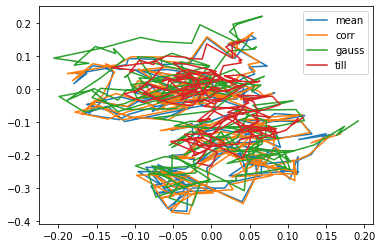

In [102]:
plt.plot(tra_mean[:,0],tra_mean[:,1], label='mean')
plt.plot(tra_corr[:,0],tra_corr[:,1], label='corr')
plt.plot(tra_gauss[:,0],tra_gauss[:,1], label='gauss')
plt.plot(tra_till[:,0],tra_till[:,1], label='till')

plt.legend()

In [109]:

def xy_to_rp(x, y):
    # Convert Cartesian to polar coordinates
    r = np.sqrt(x**2 + y**2)
    p = np.arctan2(y, x)
    return r, p

def compare_multiple_trajectories(trajectories, names, size_scale=100):
    n = len(trajectories)
    fig, axs = plt.subplots(2*n, n, figsize=(15, 30))

    for i, trajectorie_i in enumerate(trajectories):
        for j, trajectorie_j in enumerate(trajectories):
            steps_i, steps_j = [], []
            
            for k in range(len(trajectorie_i) - 1):
                steps_i.append(trajectorie_i[k+1] - trajectorie_i[k])
                steps_j.append(trajectorie_j[k+1] - trajectorie_j[k])
                
            steps_polar_i = np.array([xy_to_rp(s[0], s[1]) for s in steps_i])
            steps_polar_j = np.array([xy_to_rp(s[0], s[1]) for s in steps_j])

            # Plot step lengths
            axs[i, j].scatter(steps_polar_i[:, 0], steps_polar_j[:, 0])
            axs[i, j].axline((0, 0), slope=1, color='red', linestyle='--')
            
            # Plot angles
            axs[i+n, j].scatter(steps_polar_i[:, 1], steps_polar_j[:, 1])
            axs[i+n, j].axline((0, 0), slope=1, color='red', linestyle='--')
            
            # Only set titles for the top row and labels for the leftmost plots
            if i == 0:
                axs[i, j].set_title(names[j])
            if j == 0:
                axs[i, 0].set_ylabel(f"Step Lengths: {names[i]}")
                axs[i+n, 0].set_ylabel(f"Angles: {names[i]}")

    plt.tight_layout()
    plt.show()



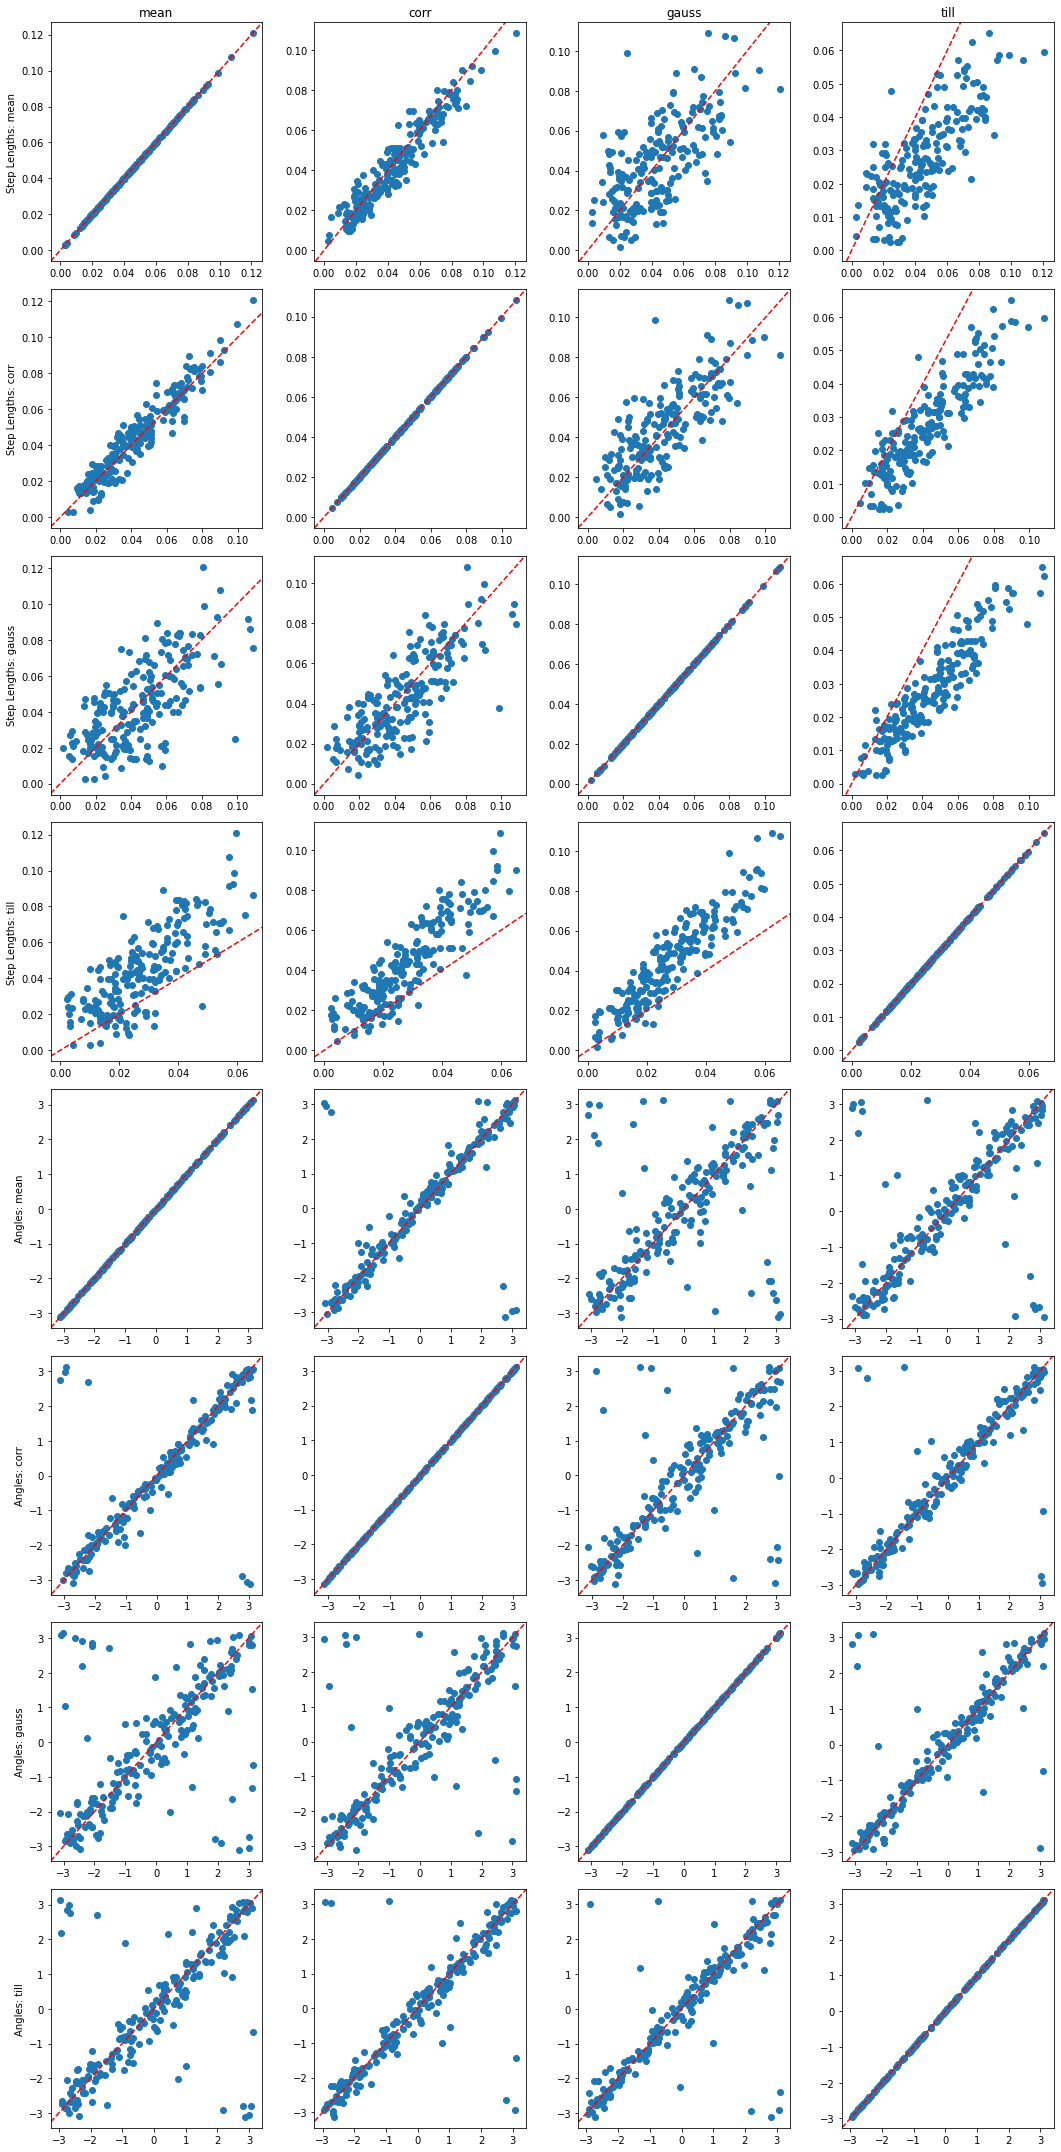

In [110]:
trajectories = [tra_mean, tra_corr, tra_gauss, tra_till]
names = ['mean', 'corr', 'gauss', 'till']

compare_multiple_trajectories(trajectories, names)